<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch-2E/blob/main/Chapter03/Varying_batch_size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms 

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(2025)

In [2]:
data_folder = '../data/FMNIST' # This can be any directory you want to 


transform = transforms.Compose([
    transforms.ToTensor()   #这个函数会将数据归一化
])

# batch_size=32
batch_size=10000

def get_data(): 
    train_dataset = datasets.FashionMNIST(root=data_folder, train=True, transform=transform, download=True)
    test_dataset = datasets.FashionMNIST(root=data_folder, train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    return train_loader,test_loader


In [3]:
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    model.eval()
    # this is the same as @torch.no_grad 
    # at the top of function, only difference
    # being, grad is not computed in the with scope
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [4]:
@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [5]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [6]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for x,y in trn_dl:
        x=x.to(device)
        y=y.to(device)
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for x,y in trn_dl:
        x=x.to(device)
        y=y.to(device)
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for x,y in val_dl:
        x=x.to(device)
        y=y.to(device)
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


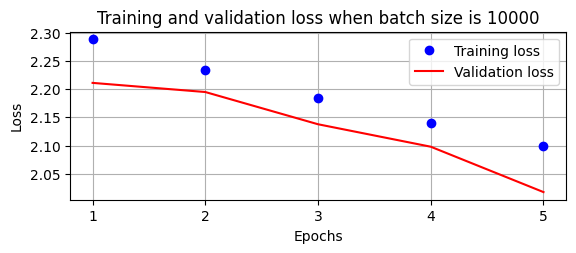

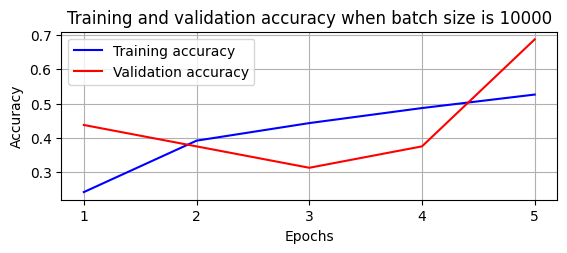

In [7]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation loss when batch size is {batch_size}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(f'Training and validation accuracy when batch size is {batch_size}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()